# Predicting Credit Card Default

### Data Set Information:

**This research aimed at the case of customers default payments in Taiwan**

### Features description:

- LIMIT_BAL: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- SEX: Gender (1 = male; 2 = female). 
- EDUCATION: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- MARRIAGE: Marital status (1 = married; 2 = single; 3 = others). 
- AGE: Age (year). 
- PAY_0 - PAY_6: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 0 = the repayment status in September, 2005; 1 = the repayment status in August, 2005; . . .; 6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- BILL_AMT1-BILL_AMT6: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 
- PAY_AMT1-PAY_AMT6: Amount of previous payment (NT dollar).
- default payment next month: **positive class: default | negative class: pay**

In [130]:
# Importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Data Preparation

In [131]:
default = pd.read_csv('data/credit_card_default.csv', index_col="ID")
# Cange column names to lower case
default.columns = default.columns.str.lower()
# For pay features if the <= 0 then it means it was not delayed. Set all negativ values to 0
pay_features = ['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']
for p in pay_features:
    default.loc[default[p]<=0, p] = 0
# Rename target to shorter name
default.rename(columns={'default payment next month':'default'}, inplace=True) 

In [132]:
default.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,0,0,0,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,0,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,0,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [133]:
# Create dummy variables
# Base values: female, other_education, not_married
# == return True or False and astype('int') coverts to 1 for True and 0 for False
default['grad_school'] = (default['education'] == 1).astype('int')
default['university'] = (default['education'] == 2).astype('int')
default['high_school'] = (default['education'] == 3).astype('int')
default['male'] = (default['sex']==1).astype('int')
default['married'] = (default['marriage'] == 1).astype('int')
# Remove columns
default.drop(['education', 'sex', 'marriage'] , axis=1, inplace=True)

In [134]:
default.head()

,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,...,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,grad_school,university,high_school,male,married
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,24,2,2,0,0,0,0,3913,3102,...,0,0,0,0,1,0,1,0,0,1
2,120000,26,0,2,0,0,0,2,2682,1725,...,1000,1000,0,2000,1,0,1,0,0,0
3,90000,34,0,0,0,0,0,0,29239,14027,...,1000,1000,1000,5000,0,0,1,0,0,0
4,50000,37,0,0,0,0,0,0,46990,48233,...,1200,1100,1069,1000,0,0,1,0,0,1
5,50000,57,0,0,0,0,0,0,8617,5670,...,10000,9000,689,679,0,0,1,0,1,1


# Building models using all features

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
#from sklearn.preprocessing import RobustScaler

In [136]:
# Check if data is imbalanced
count = default['default'].value_counts()
imbalance = pd.DataFrame(count)
percent = imbalance['default'] / imbalance['default'].sum() * 100
imbalance['%'] = percent
imbalance


,default,%
0,23364,77.88
1,6636,22.12


In [137]:
# Create training and test sets
target_name = 'default'
x = default.drop('default', axis=1)
#robust_scaler = RobustScaler()
#x = robust_scaler.fit_transform(x)
y = default[target_name]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, stratify=y)

### Stratify
Stratify is to make sure imbalanced data has the same percentage of each class in the split.

### Preparing a DataFrame for model analysis

In [138]:
# Data frame for evaluation metrics
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'f1'], 
                      columns=['NULL','LogisticReg', 'ClassTree', 'NaiveBayes'])

### Error metrics
- **Accuracy**: the proportion of the total number of predictions that are correct, (TP+TN)/Total​
- **Precision**: the proportion of positive predictions that are actually correct, TP/(TP+FP)​ 
- **Recall**: the proportion of positive observed values correctly predicted as such, TP/(TP+FN) 
- **F1**: Combination of precision and recall, 2*(recision*recall)/(precision+recall)

**In this application:**
- **Accuracy**: Overall how often the model predicts correctly defaulters and non-defaulters
- **Precision**: When the model predicts **default**: how often is correct?
- **Recall**: The proportion of **actual defaulters** that the model will correctly predict as such

#### Which metric should I use?

- **False Positive**: A person who will pay predicted as defaulter
- **False Negative**: A person who will default predicted as payer

#### False negatives are worse => look for a better recall

## The Null model: always predict the most common category

In [139]:
# Count occurance of each category and idxmax() is selecting the most occured being 0
frequent_class = y_train.value_counts().idxmax()
print('Most frequent class: ',frequent_class)
y_pred_test = np.repeat(frequent_class, y_test.size)


Most frequent class:  0


/Users/evahegnar/opt/miniconda3/envs/pred_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


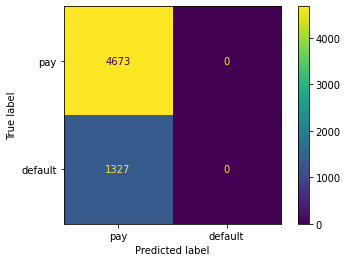

In [140]:
metrics.loc['accuracy','NULL'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NULL'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NULL'] = recall_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['f1','NULL'] = f1_score(y_pred=y_pred_test, y_true=y_test)

cm = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
disp = ConfusionMatrixDisplay(cm, display_labels=['pay', 'default'])
disp.plot();

## A. Logistic Regression

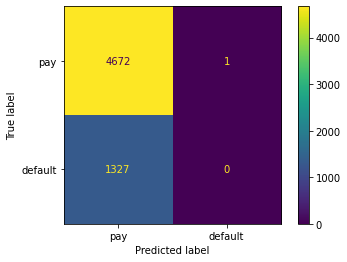

In [141]:
# 1. Import the estimator object (model)
from sklearn.linear_model import LogisticRegression

# 2. Create an instance of the estimator
logistic_regression = LogisticRegression(n_jobs=-1, random_state=15, max_iter=1000)

# 3. Use the trainning data to train the estimator
logistic_regression.fit(x_train, y_train)

# 4. Evaluate the model
y_pred_test = logistic_regression.predict(x_test)
metrics.loc['accuracy','LogisticReg'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','LogisticReg'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','LogisticReg'] = recall_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['f1','LogisticReg'] = f1_score(y_pred=y_pred_test, y_true=y_test)

#Confusion matrix
cm = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
disp = ConfusionMatrixDisplay(cm, display_labels=['pay', 'default'])
disp.plot();


## B. Classification Trees

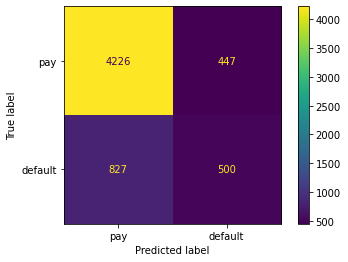

In [142]:
# 1. Import the estimator object (model)
from sklearn.tree import DecisionTreeClassifier

# 2. Create an instance of the estimator
class_tree = DecisionTreeClassifier(min_samples_split=30, min_samples_leaf=10, random_state=10)

# 3. Use the trainning data to train the estimator
class_tree.fit(x_train, y_train)

# 4. Evaluate the model
y_pred_test = class_tree.predict(x_test)
metrics.loc['accuracy','ClassTree'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','ClassTree'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','ClassTree'] = recall_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['f1','ClassTree'] = f1_score(y_pred=y_pred_test, y_true=y_test)

#Confusion matrix
cm = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
disp = ConfusionMatrixDisplay(cm, display_labels=['pay', 'default'])
disp.plot();

## C. Naive Bayes Classifier

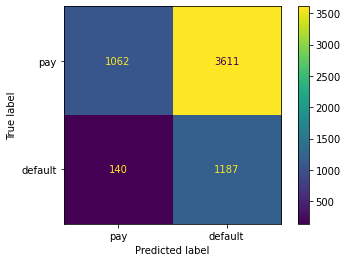

In [143]:
# 1. Import the estimator object (model)
from sklearn.naive_bayes import GaussianNB

# 2. Create an instance of the estimator
nbc = GaussianNB()

# 3. Use the training data to train the estimator
nbc.fit(x_train, y_train)

# 4. Evaluate the model
y_pred_test = nbc.predict(x_test)
metrics.loc['accuracy','NaiveBayes'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NaiveBayes'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NaiveBayes'] = recall_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['f1','NaiveBayes'] = f1_score(y_pred=y_pred_test, y_true=y_test)

#Confusion matrix
cm = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
disp = ConfusionMatrixDisplay(cm, display_labels=['pay', 'default'])
disp.plot();

### Model evaluation

In [144]:
metrics

,NULL,LogisticReg,ClassTree,NaiveBayes
accuracy,0.778833,0.778667,0.787667,0.374833
precision,0.0,0.0,0.527983,0.247395
recall,0.0,0.0,0.37679,0.894499
f1,0.0,0.0,0.439754,0.387592


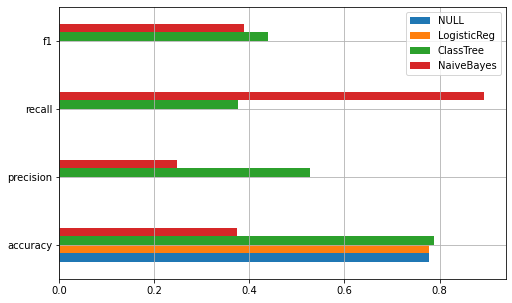

In [145]:
fig, ax = plt.subplots(figsize=(8,5))
metrics.plot(kind='barh', ax=ax)
ax.grid();

### Threshold
- Classification algorithms classify to postitive (1) och negative (0) class by using probability and threshold value 
- Threshold is the least probability classifying an observation to the postive class
- Default is 0.5 (50%)
- Threshold can be tuned to improve precision and recall
- Scikit-learn compute precision-recall pairs for different probability thresholds to find optimal threshold

In [112]:
nbc.predict_proba(x_test)

array([[0.18624585, 0.81375415],
       [0.16829497, 0.83170503],
       [0.1055521 , 0.8944479 ],
       ...,
       [0.15790021, 0.84209979],
       [0.17423842, 0.82576158],
       [0.15073336, 0.84926664]])

In [119]:
# Threshold
# predict_proba returns array (n_samples, n_classes), use [:,1] to get positive class default 
precision_nb, recall_nb, thresholds_nb = precision_recall_curve(y_true=y_test, 
                                            probas_pred=nbc.predict_proba(x_test)[:,1])
precision_tree, recall_tree, thresholds_tree = precision_recall_curve(y_true=y_test, 
                                            probas_pred=class_tree.predict_proba(x_test)[:,1])

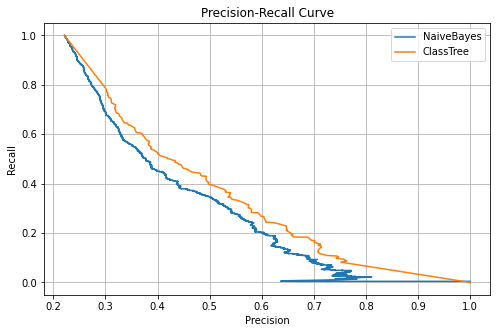

In [118]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(precision_nb, recall_nb, label='NaiveBayes')
ax.plot(precision_tree, recall_tree, label='ClassTree')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.legend()
ax.grid();

### Confusion matrix for modified Logistic Regression Classifier

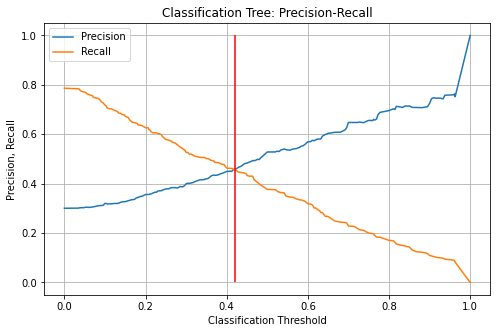

In [123]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(thresholds_tree, precision_tree[1:], label='Precision')
ax.plot(thresholds_tree, recall_tree[1:], label='Recall')
ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Precision, Recall')
ax.set_title('Classification Tree: Precision-Recall')
ax.vlines(x=0.42, ymin=0, ymax=1, color='red')
ax.legend()
ax.grid();

### Classifier with threshold of 0.42

Recall:  45.81763376036172
Precision:  45.67993989481593


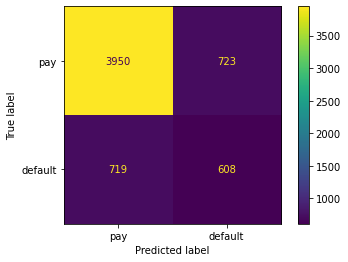

In [124]:
y_pred_proba = class_tree.predict_proba(x_test)[:,1]
y_pred_test = (y_pred_proba >= 0.42).astype('int')
#Confusion matrix
cm = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
print("Recall: ", 100*recall_score(y_pred=y_pred_test, y_true=y_test))
print("Precision: ", 100*precision_score(y_pred=y_pred_test, y_true=y_test))
disp = ConfusionMatrixDisplay(cm, display_labels=['pay', 'default'])
disp.plot();

### Making individual predictions

In [127]:
def make_ind_prediction(new_data):
    data = new_data.values.reshape(1, -1)
    #data = robust_scaler.transform(data)
    prob = class_tree.predict_proba(data)[0][1]
    if prob >= 0.42:
        return 'Will default'
    else:
        return 'Will pay'

In [128]:
from collections import OrderedDict
new_customer = OrderedDict([('limit_bal', 4000),('age', 50 ),('bill_amt1', 500),
                            ('bill_amt2', 35509 ),('bill_amt3', 689 ),('bill_amt4', 0 ),
                            ('bill_amt5', 0 ),('bill_amt6', 0 ), ('pay_amt1', 0 ),('pay_amt2', 35509 ),
                            ('pay_amt3', 0 ),('pay_amt4', 0 ),('pay_amt5', 0 ), ('pay_amt6', 0 ),
                            ('male', 1 ),('grad_school', 0 ),('university', 1 ), ('high_school', 0 ),
                            ('married', 1 ),('pay_0', -1 ),('pay_2', -1 ),('pay_3', -1 ),
                            ('pay_4', 0),('pay_5', -1), ('pay_6', 0)])

new_customer = pd.Series(new_customer)
make_ind_prediction(new_customer)

/Users/evahegnar/opt/miniconda3/envs/pred_env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


'Will pay'